# Problema 2 - Discretización de la estructura arterial.

## Librerias

In [1]:
from skimage.morphology import skeletonize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json
import os

## Funciones para Discretizacion de imagen

### Preprocesamiento y Esqueletización

In [2]:
def load_and_preprocess_image(img_path):
    """
    Carga la imagen y la binariza sin invertir los valores y luego aplica esqueletización.

    Args:
        - img_path (str): Ruta de la imagen a cargar.

    Returns:
        - skeleton (np.ndarray): Imagen esqueletizada.
    """
    image = imread(img_path, as_gray=True) # Cargar imagen en escala de grises
    binary_image = image > 0.5          # Binarizar imagen
    skeleton = skeletonize(binary_image)  # Aplicar esqueletización
    return skeleton.astype(np.uint8)    # Convertir a uint8

#### Identificación de pixeles vecinos

In [3]:
def find_pixel_neighbors(img, x, y):
    """
    Obtiene los vecinos de un píxel en la imagen binaria.

    Args:
        - img (np.array): Imagen binaria.
        - x (int): Coordenada x del píxel.
        - y (int): Coordenada y del píxel.

    Returns:
        list: Lista de tuplas con las coordenadas de los vecinos.
    """
    # Coordenadas de los vecinos, en sentido horario.
    neighbors = [
        (x-1, y-1), (x-1, y), (x-1, y+1),
        (x,   y-1),           (x,   y+1),
        (x+1, y-1), (x+1, y), (x+1, y+1)
    ]

    # Filtrar los vecinos que están dentro de la imagen y son 1.
    return [(i, j) for i, j in neighbors if 0 <= i < img.shape[0] and 0 <= j < img.shape[1] and img[i, j] == 1]

### Construccion del Grafo inicial

In [4]:
def build_graph(skeleton):
    """
    Construye un grafo usando NetworkX donde los nodos son los píxeles del esqueleto.
    Los nodos están conectados si son vecinos en la imagen binaria.

    Args:
        - skeleton (np.ndarray): Imagen binaria esqueletizada.

    Returns:
        - G (nx.Graph): Grafo construido.
    """
    G = nx.Graph()
    rows, cols = skeleton.shape
    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                neighbors = find_pixel_neighbors(skeleton, x, y)
                for neighbor in neighbors:
                    G.add_edge((x, y), neighbor)
    return G

### Clasificación de Nodos

In [5]:
def classify_nodes(G):
    """
    Clasifica los nodos en extremos, intermedios, bifurcaciones y trifurcaciones.

    Args:
        - G (nx.Graph): Grafo de la red de estructura arterial.

    Returns:
        - nodes (dict): Diccionario con los nodos clasificados.
    """
    # Inicializar diccionario de nodos
    nodes = {"extremos": [], "intermedios": [], "bifurcaciones": [], "trifurcaciones": []}
    
    # Clasificar nodos
    for node in G.nodes:
        degree = len(list(G.neighbors(node)))
        if degree == 1:
            nodes["extremos"].append(node)
        elif degree == 2:
            nodes["intermedios"].append(node)
        elif degree == 3:
            nodes["bifurcaciones"].append(node)
        else:
            nodes["trifurcaciones"].append(node)
    return nodes


### Filtrado y Simplificación de Nodos

In [6]:
def dfs_reduce_intermediates(G, nodes, step=3):
    """
    Reduce la cantidad de nodos intermedios usando un recorrido DFS y conservando 1 de cada 'step' nodos.

    Args:
        - G (nx.Graph): Grafo de NetworkX.
        - nodes (dict): Diccionario con los nodos clasificados.
        - step (int): Cada cuántos nodos intermedios se conserva uno.

    Returns:
        - H (nx.Graph): Grafo reducido.
    """
    # Hacer una copia del grafo original
    H = G.copy()
    # Inicializar variables
    visited = set()
    stack = list(nodes["extremos"])  # Usamos DFS con una pila
    count = 0

    # Recorrer el grafo
    while stack:
        # Sacar un nodo de la pila
        node = stack.pop()
        # Si ya visitamos el nodo, continuar
        if node in visited:
            continue
        # Marcar el nodo como visitado
        visited.add(node)
        neighbors = list(H.neighbors(node))
        # Si el nodo es un nodo intermedio y no es un múltiplo de 'step', eliminarlo
        if len(neighbors) == 2 and count % step != 0:
            H.add_edge(neighbors[0], neighbors[1])
            H.remove_node(node)
        # Incrementar el contador
        count += 1
        stack.extend(neighbors)

    return H

In [7]:
def merge_branching_chains(G, nodes):
    """
    Fusiona grupos consecutivos de bifurcaciones y trifurcaciones en un solo nodo representativo.
    Se considera que dos nodos de bifurcación o trifurcación están conectados si existe un camino entre ellos
    que solo pasa por nodos de bifurcación o trifurcación.
    El nodo representativo es el nodo más central en la lista de nodos conectados.
    Se eliminan los nodos de bifurcación y trifurcación que no son representativos.

    Args:
        - G (nx.Graph): Grafo de la red de vasos sanguíneos.
        - nodes (dict): Diccionario con los nodos clasificados en extremos, intermedios, bifurcaciones y trifurcaciones.

    Returns:
        - H (nx.Graph): Grafo con las bifurcaciones y trifurcaciones fusionadas.
    """
    H = G.copy()
    all_branching_nodes = set(nodes["bifurcaciones"] + nodes["trifurcaciones"])
    visited = set()
    
    # Iterar sobre todos los nodos de bifurcación
    for node in all_branching_nodes:
        
        # Si ya se visitó o no está en el grafo, continuar
        if node in visited or node not in H:
            continue
        
        # Encontrar la cadena de bifurcaciones conectadas
        chain = []
        stack = [node]
        while stack:
            current = stack.pop()
            # Si ya se visitó o no está en el conjunto de nodos de bifurcación, continuar
            if current in visited or current not in all_branching_nodes:
                continue

            # Agregar a la cadena y visitar los vecinos
            visited.add(current)
            chain.append(current)

            # Agregar los vecinos que son nodos de bifurcación
            for neighbor in H.neighbors(current):
                if neighbor in all_branching_nodes and neighbor not in visited:
                    stack.append(neighbor)
        
        # Determinar el nodo representativo (el más central en la lista)
        if len(chain) > 1:
            central_node = chain[len(chain) // 2]
            for merge_node in chain:
                if merge_node == central_node:
                    continue
                for neighbor in list(H.neighbors(merge_node)):
                    if neighbor != central_node:
                        H.add_edge(central_node, neighbor)
                H.remove_node(merge_node)
    
    return H


### Visualización de la estructura arterial discretizada

In [8]:

def visualize_graph(image, G, nodes, output_path):
    """
    Visualiza el grafo con colores según la clasificación de nodos y guarda la imagen sin bordes blancos.

    Los nodos se clasifican en:
    - Extremos (verde)
    - Intermedios (gris)
    - Bifurcaciones (rojo)
    - Trifurcaciones (azul)

    Args:
        - image (np.array): Imagen original.
        - G (nx.Graph): Grafo de la red de vasos sanguíneos.
        - nodes (dict): Diccionario con los nodos clasificados en extremos, intermedios, bifurcaciones y trifurcaciones.
        - output_path (str): Ruta donde guardar la imagen.

    Returns:
        - None
    """
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)  # 1000x1000 px
    ax.imshow(image, cmap="gray", extent=[0, 300, 300, 0])  # Ajustar imagen al tamaño de la figura original (300x300 px)

    # Posiciones de los nodos (invertir coordenadas para que coincidan con la imagen)
    pos = {node: (node[1], node[0]) for node in G.nodes}
       
    # Dibujar aristas en amarillo con grosor aumentado
    nx.draw(G, pos, edge_color='yellow', node_size=0, with_labels=False, ax=ax, width=2)  # Dibujar aristas

    # Dibujar nodos con tamaño aumentado
    nx.draw_networkx_nodes(G, pos, nodelist=nodes["intermedios"], node_color='gray', node_size=125, ax=ax) 
    nx.draw_networkx_nodes(G, pos, nodelist=nodes["bifurcaciones"], node_color='red', node_size=300, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes["trifurcaciones"], node_color='blue', node_size=300, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes["extremos"], node_color='green', node_size=300, ax=ax)

    # Configurar los límites exactos a 300x300 píxeles
    ax.set_xlim([0, 300])
    ax.set_ylim([300, 0])  # Invertimos para alinear la imagen correctamente

    # Eliminar ejes y márgenes completamente
    ax.set_axis_off()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Ajuste fino

    # Guardar la imagen sin márgenes blancos
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=100)
    plt.close()

### Almacenado de Datos del grafo discretizado

In [9]:
def save_graph_json(G, nodes, output_path):
    """
    Guarda la estructura del grafo en un archivo JSON.

    Args:
        - G (nx.Graph): Grafo de NetworkX.
        - nodes (dict): Diccionario con los nodos clasificados.
        - output_path (str): Ruta del archivo de salida.

    Returns:
        - None
    """
    # Crear un diccionario con la estructura del grafo
    graph_data = {
        "nodos": list(G.nodes),
        "extremos": nodes["extremos"],
        "intermedios": nodes["intermedios"],
        "bifurcaciones": nodes["bifurcaciones"],
        "trifurcaciones": nodes["trifurcaciones"],
        "aristas": list(G.edges)
    }
    
    # Guardar el diccionario en un archivo JSON
    with open(output_path, "w") as json_file:
        json.dump(graph_data, json_file, indent=4)


### Discretizacion

In [10]:
def discretize_arteries(image_path):
    """
    Procesa la imagen de una estructura arterial y guarda el grafo y la visualización en un archivo JSON.

    Args:
        - image_path (str): Ruta de la imagen a procesar.

    Returns:
        - None
    """
    skeleton = load_and_preprocess_image(image_path)
    G = build_graph(skeleton)
    nodes = classify_nodes(G)
    G_reduced = dfs_reduce_intermediates(G, nodes, step=13)
    G_final = merge_branching_chains(G_reduced, nodes)
    
    # Reclasificar después de filtrado
    final_nodes = classify_nodes(G_final)
    
    # Visualizar con los colores adecuados
    visualize_graph(skeleton, G_final, final_nodes)
    
    # Guardar en JSON
    save_graph_json(G_final, final_nodes)

### Comparación Original vs Grafo

In [11]:
def visualize_comparison(original_image_path, groundtruth_image_path, graph_image_path, n):   
    """
    Muestra la imagen original junto con su versión con grafo superpuesto.

    Args:
        - original_image_path (str): ruta de la imagen original.
        - graph_image_path (str): ruta de la imagen con el grafo superpuesto.
        - n (int): número de la imagen.

    Returns:
        - None
    """
    # Cargar imágenes
    original = imread(original_image_path)
    groundtruth = imread(groundtruth_image_path)
    graph = imread(graph_image_path)
    
    # Mostrar imágenes
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Imagen original
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title(f"Imagen Original {n}")
    ax[0].axis("off")
    
    # Imagen ground truth
    ax[1].imshow(groundtruth, cmap='gray')
    ax[1].set_title(f"Ground Truth {n}")
    ax[1].axis("off")

    # imagen con grafo
    ax[2].imshow(graph)
    ax[2].set_title(f"Discretización de estructura arterial {n}")
    ax[2].axis("off")

    # Imagen con grafo
    
    plt.show()

## Procesamiento de todas las imagenes

In [12]:
def process_all_images(database_dir, json_output_dir, image_output_dir):
    """
    Procesa todas las imágenes en la carpeta database y guarda los resultados en las carpetas de salida.

    Args:
        - database_dir (str): Directorio con las imágenes de la base de datos.
        - json_output_dir (str): Directorio de salida para los archivos JSON.
        - image_output_dir (str): Directorio de salida para las visualizaciones de los grafos.

    Returns:
        - None
    """
    # Crear directorios de salida si no existen
    os.makedirs(json_output_dir, exist_ok=True)
    os.makedirs(image_output_dir, exist_ok=True)

    # Obtener lista de archivos en la carpeta database y ordenarlos numéricamente
    files = sorted([f for f in os.listdir(database_dir) if f.endswith("_gt.pgm")], key=lambda x: int(x.split("_gt.pgm")[0]))
    
    for filename in files:
            n = filename.split("_gt.pgm")[0]  # Extraer el índice de la imagen
            image_path = os.path.join(database_dir, filename)
            original_image_path = os.path.join(database_dir, f"{n}.pgm")
            groundtruth_image_path = os.path.join(database_dir, f"{n}_gt.pgm")
            
            json_output_path = os.path.join(json_output_dir, f"{n}_graph_data.json")
            image_output_path = os.path.join(image_output_dir, f"{n}_graph_viz.png")
            
            # Ejecutar la discretización en la imagen actual
            skeleton = load_and_preprocess_image(image_path)
            G = build_graph(skeleton)
            nodes = classify_nodes(G)
            G_reduced = dfs_reduce_intermediates(G, nodes, step=13)
            G_final = merge_branching_chains(G_reduced, nodes)
            
            # Reclasificar después de filtrado
            final_nodes = classify_nodes(G_final)
            
            # Guardar visualización y JSON
            visualize_graph(skeleton, G_final, final_nodes, image_output_path)
            save_graph_json(G_final, final_nodes, json_output_path)
                        
            # Visualizar comparación
            visualize_comparison(original_image_path, groundtruth_image_path, image_output_path, n)

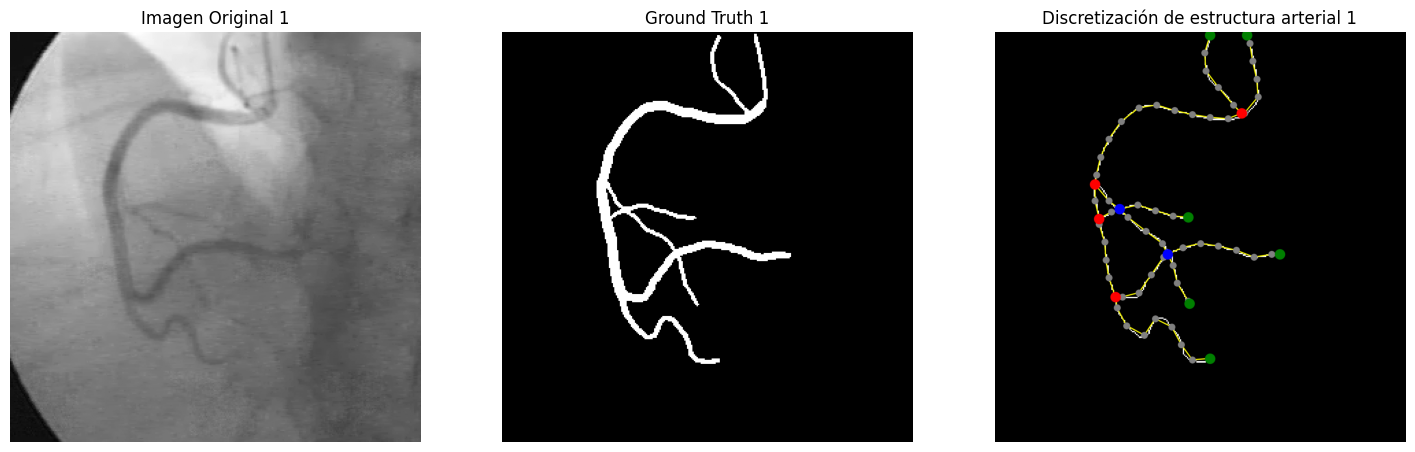

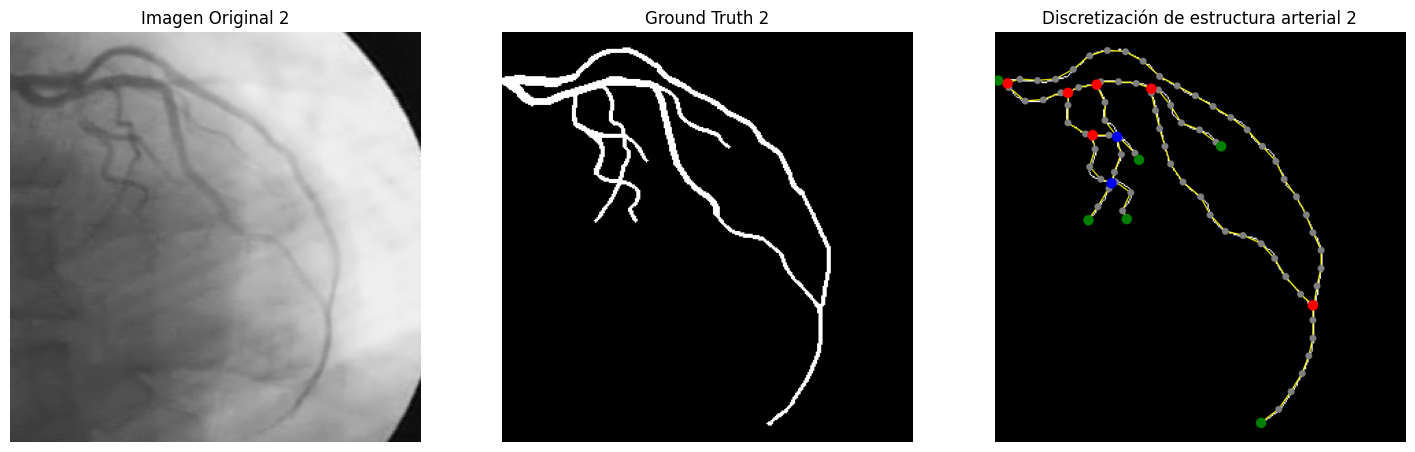

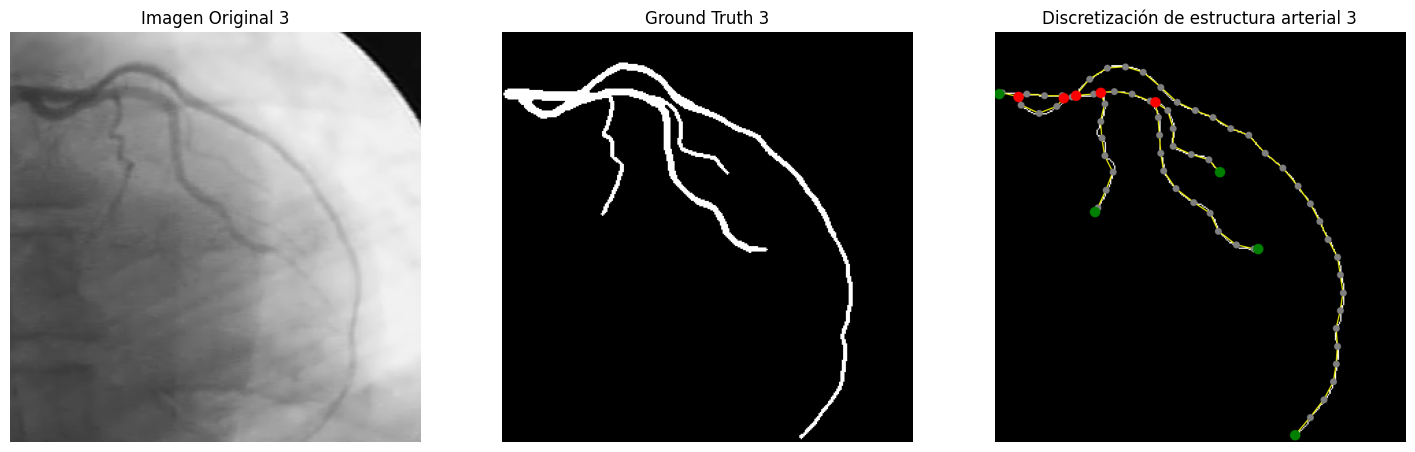

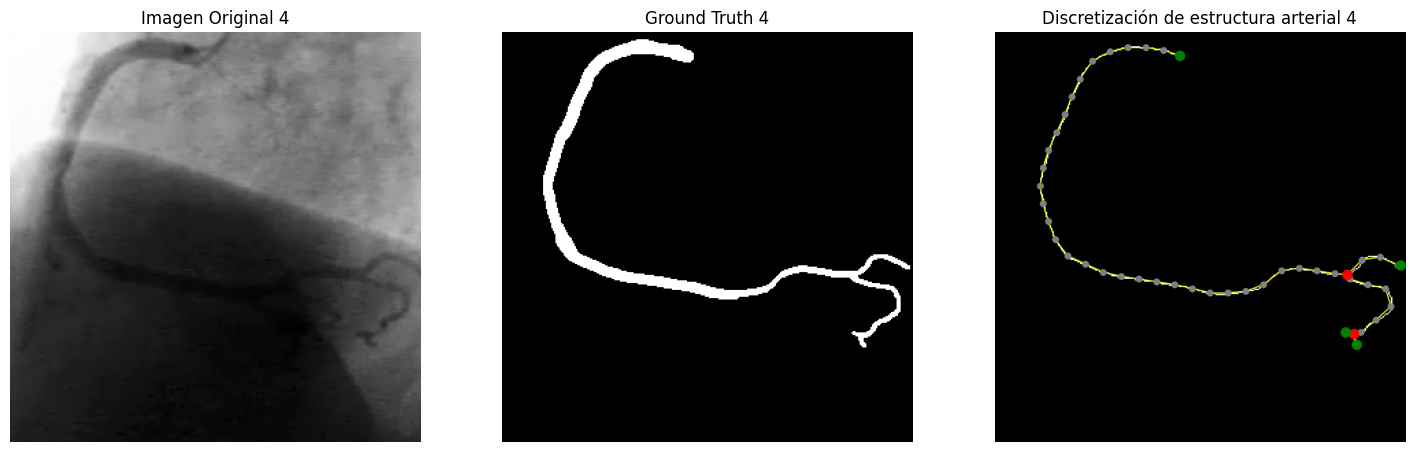

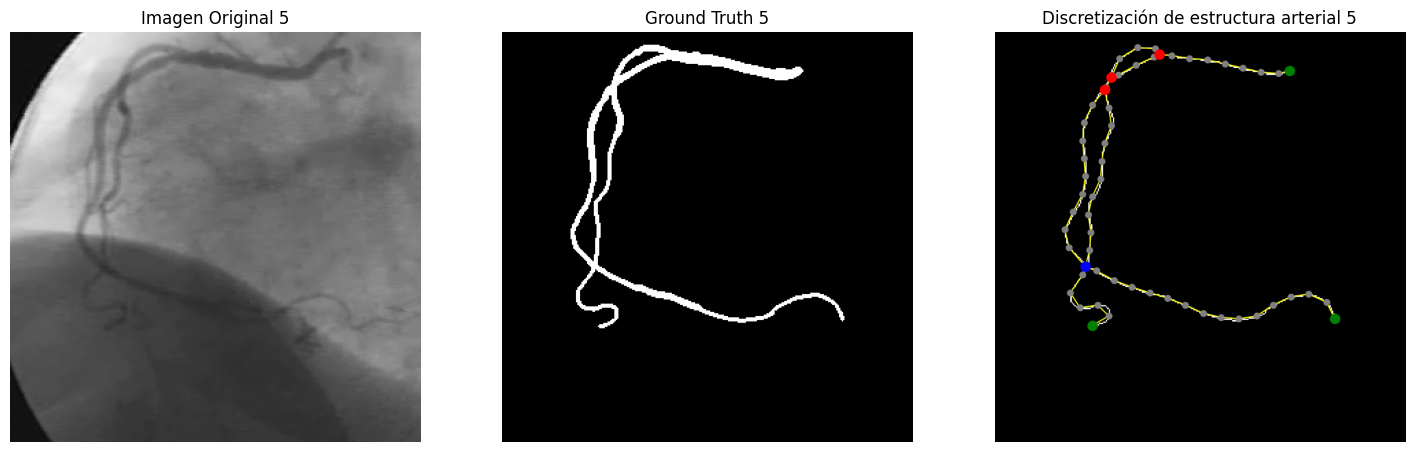

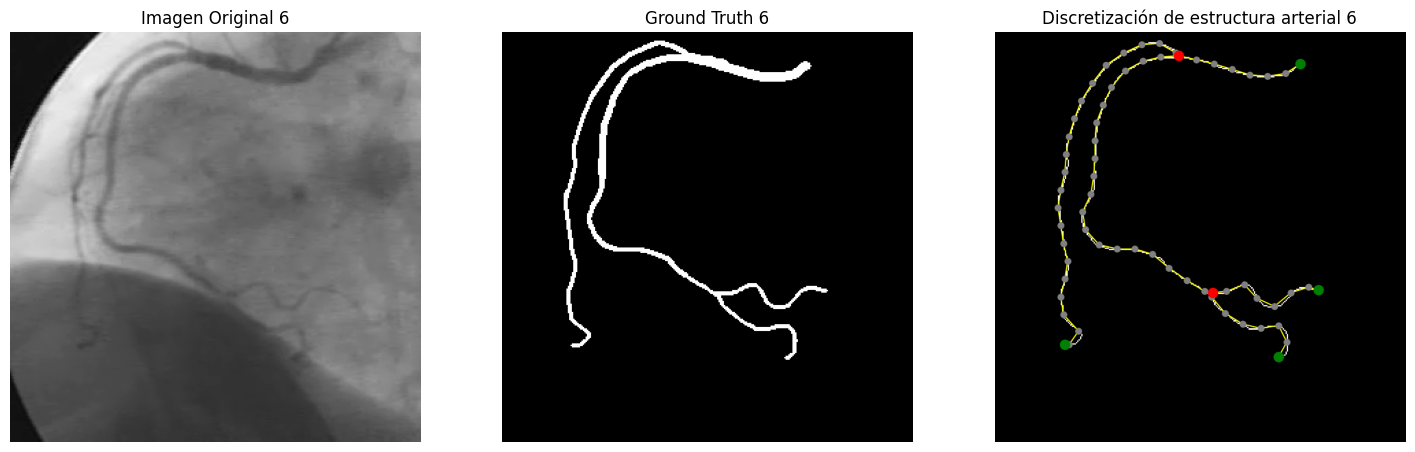

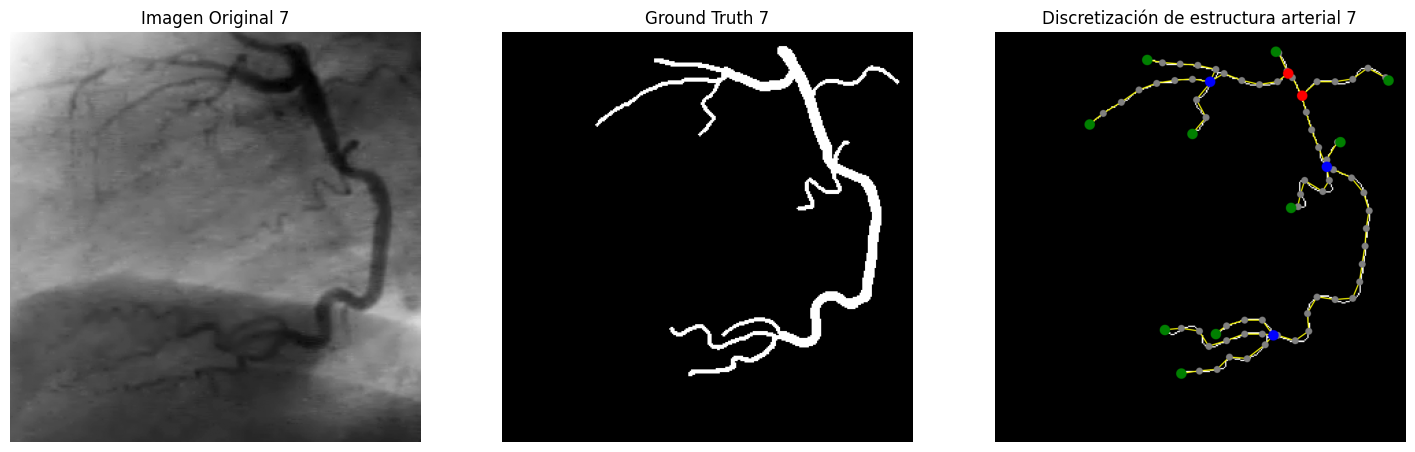

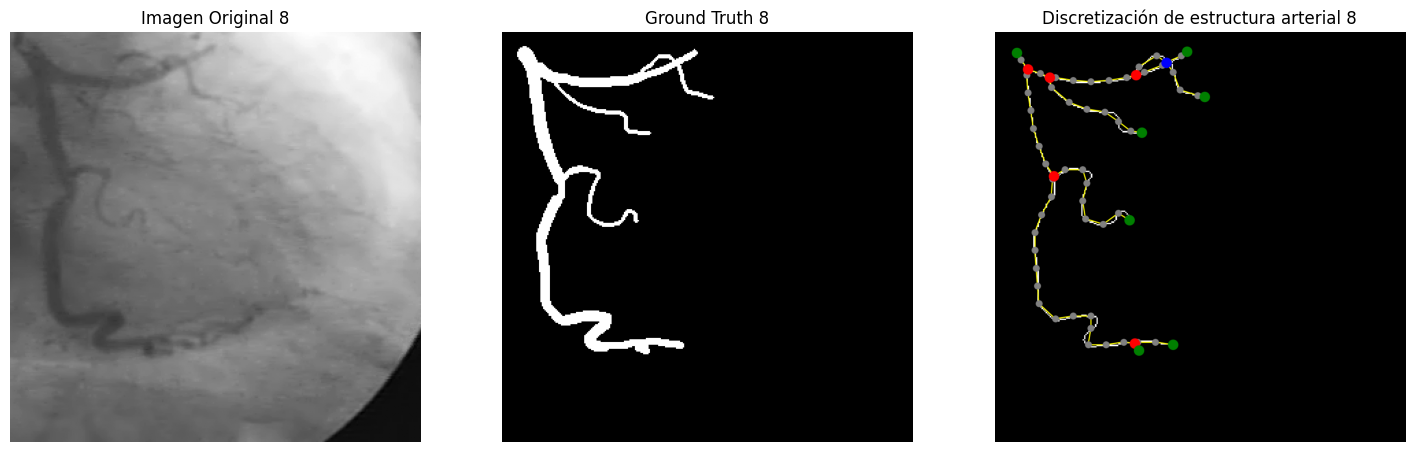

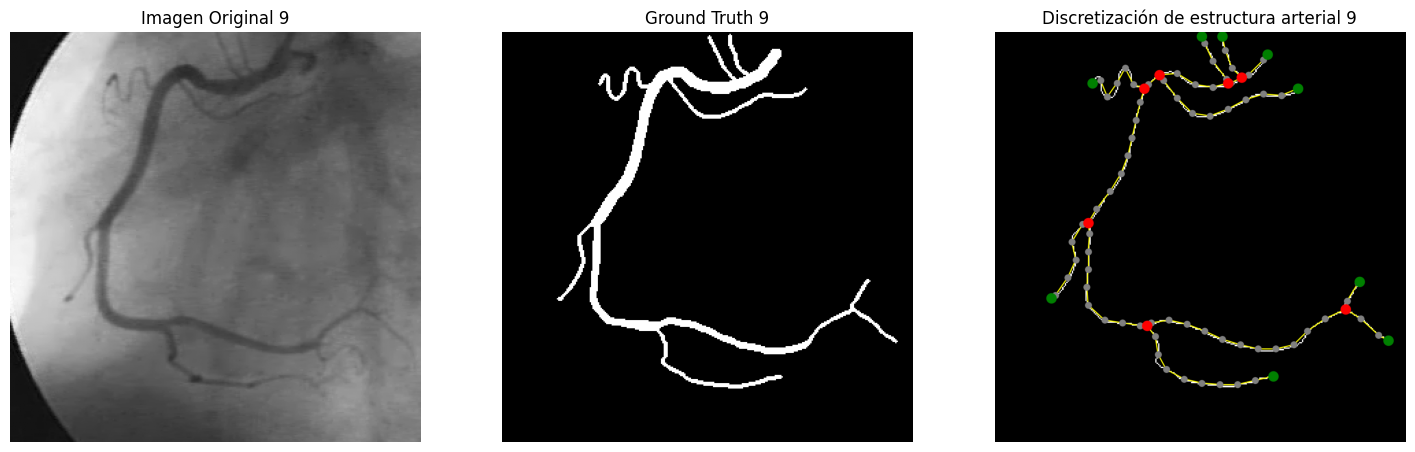

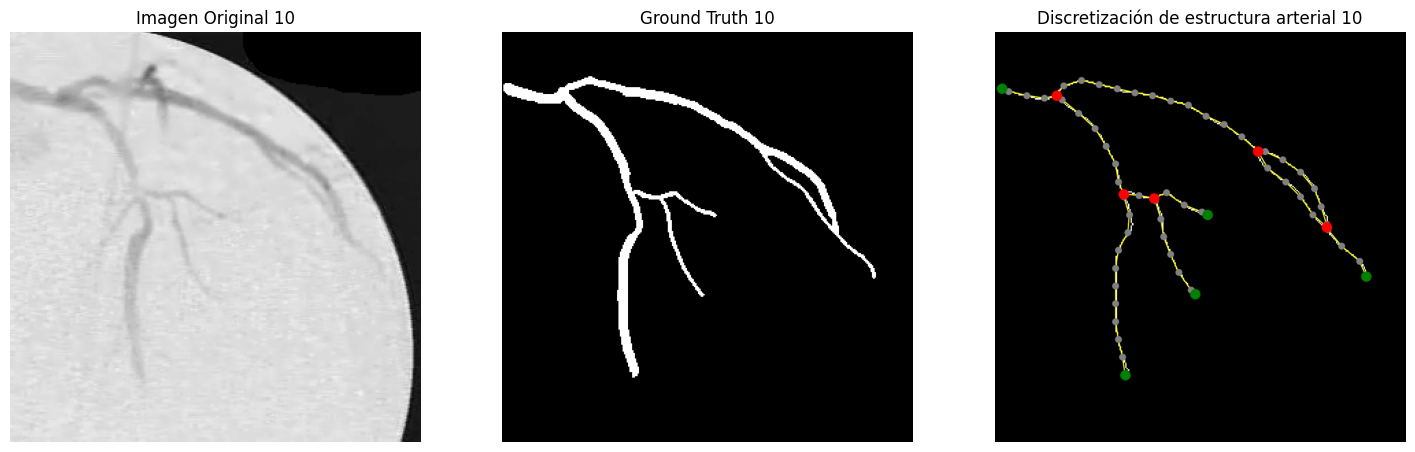

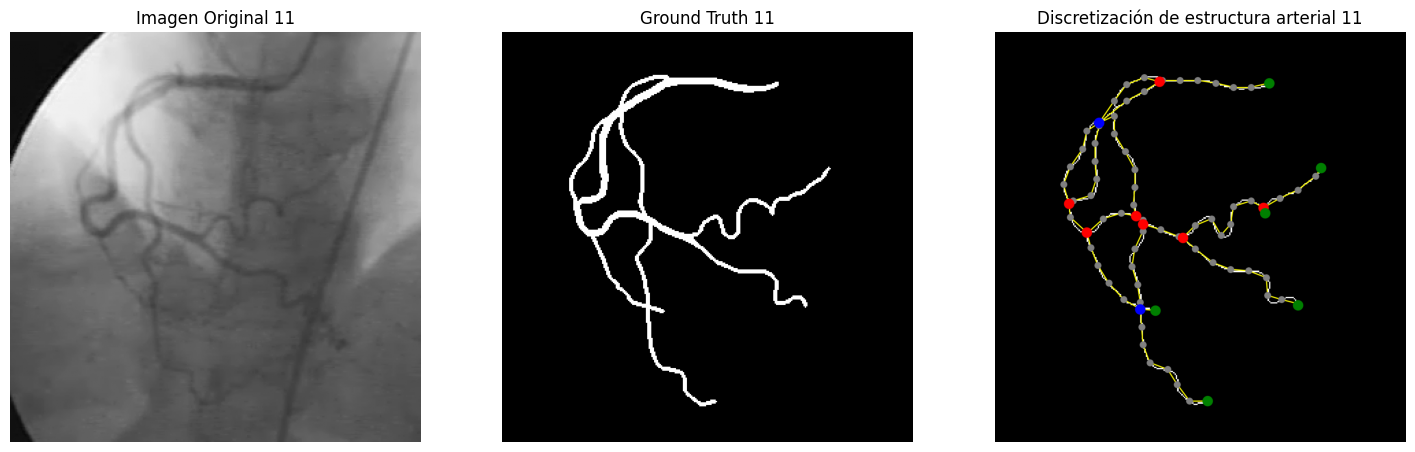

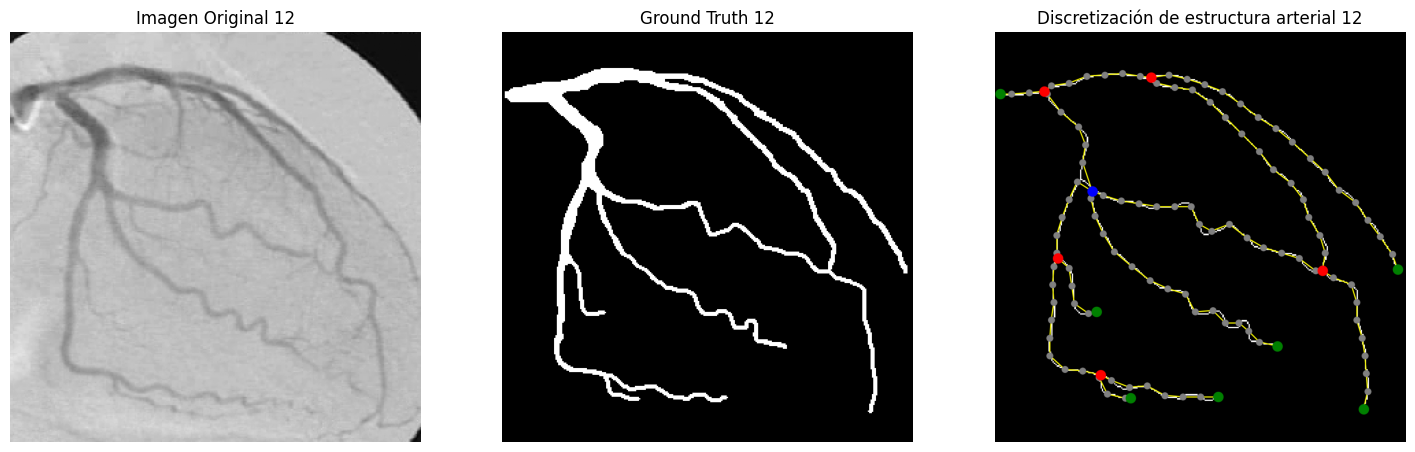

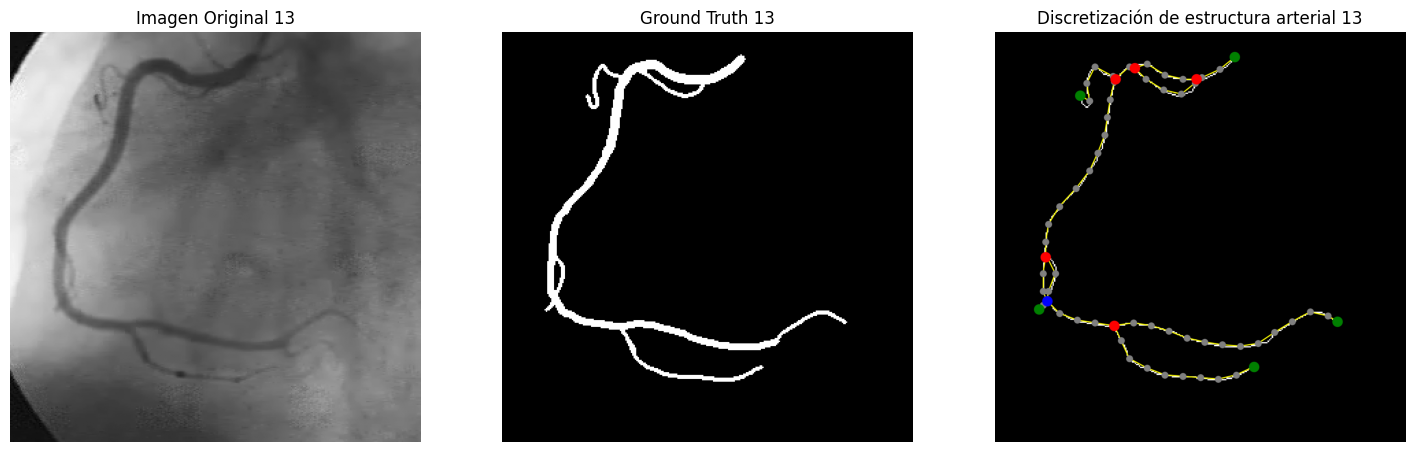

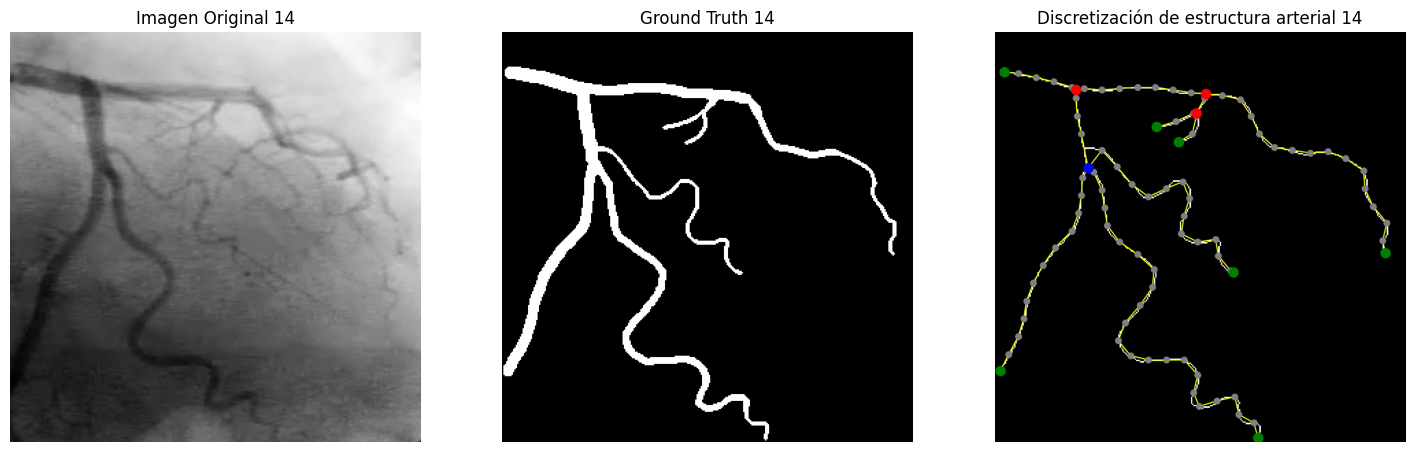

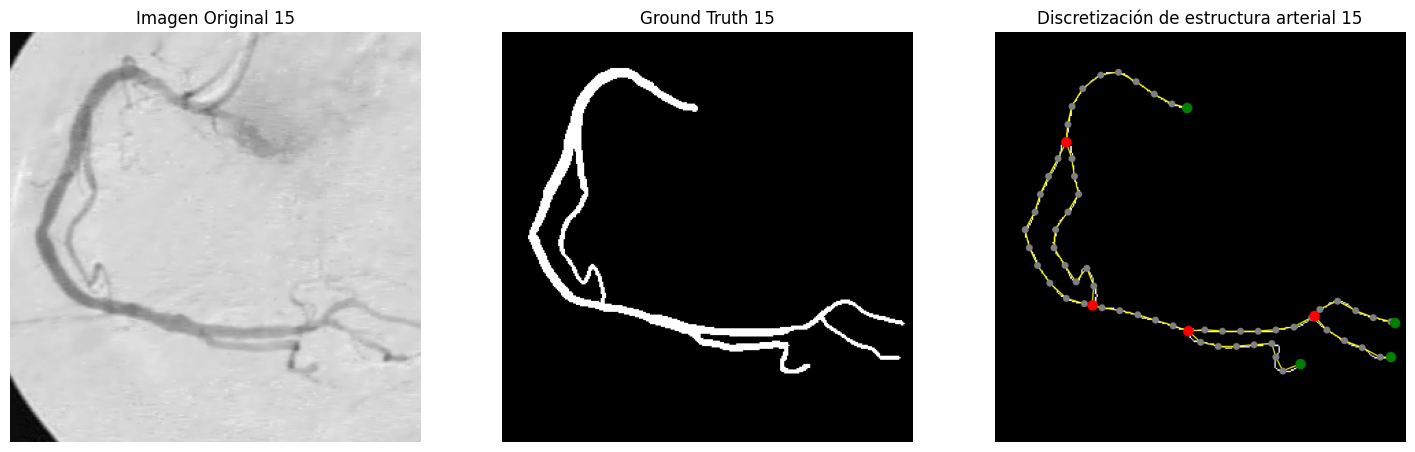

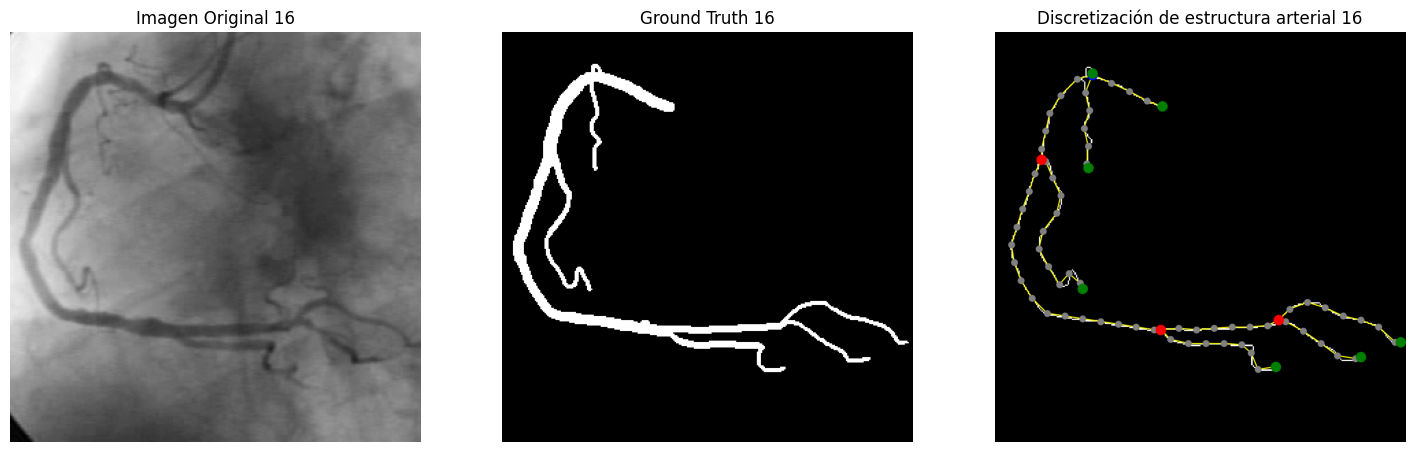

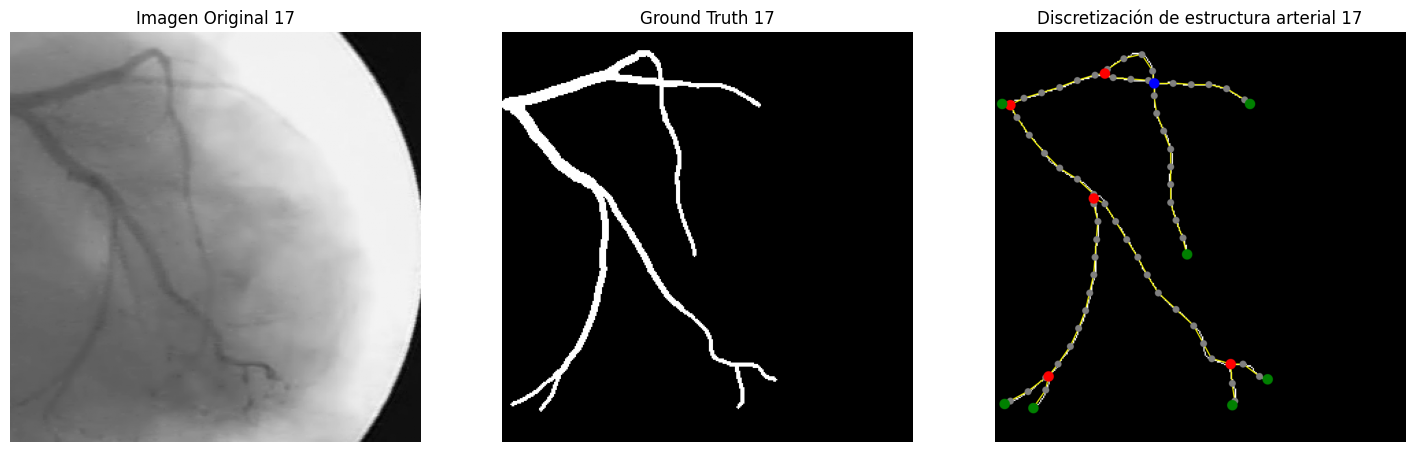

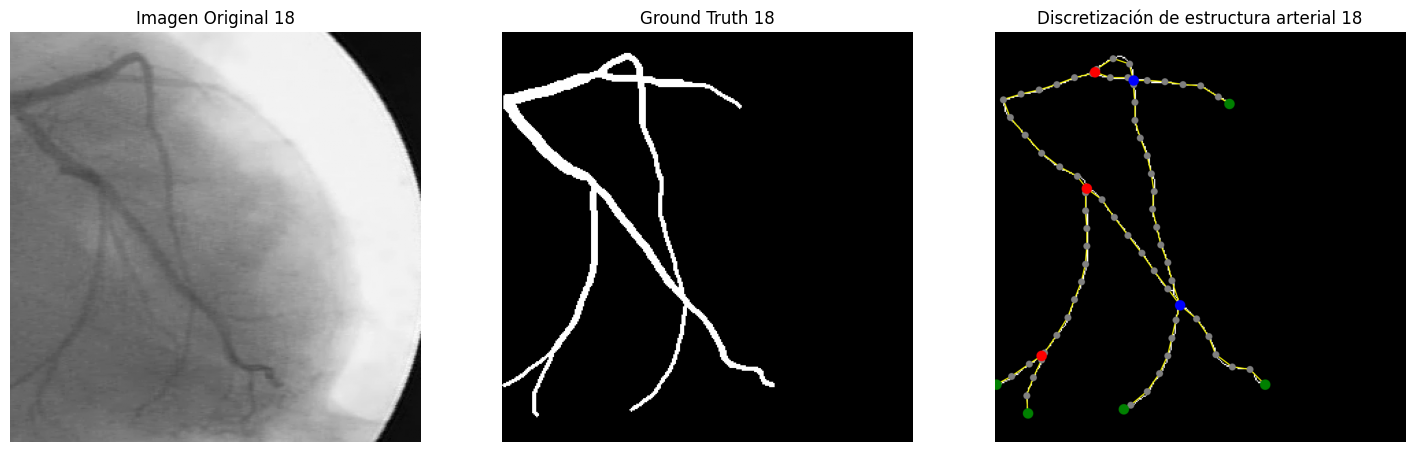

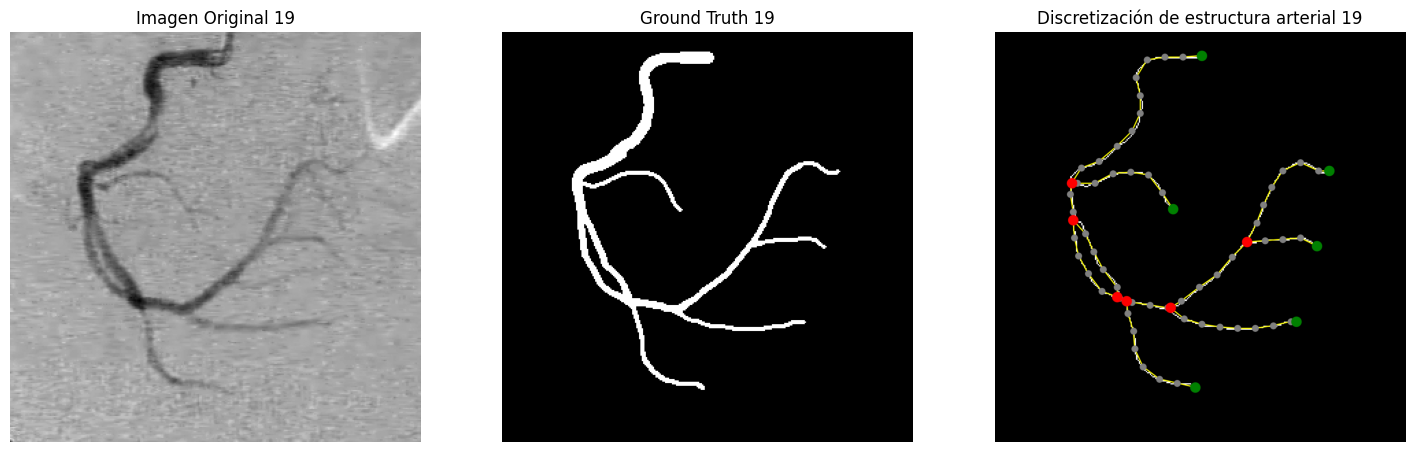

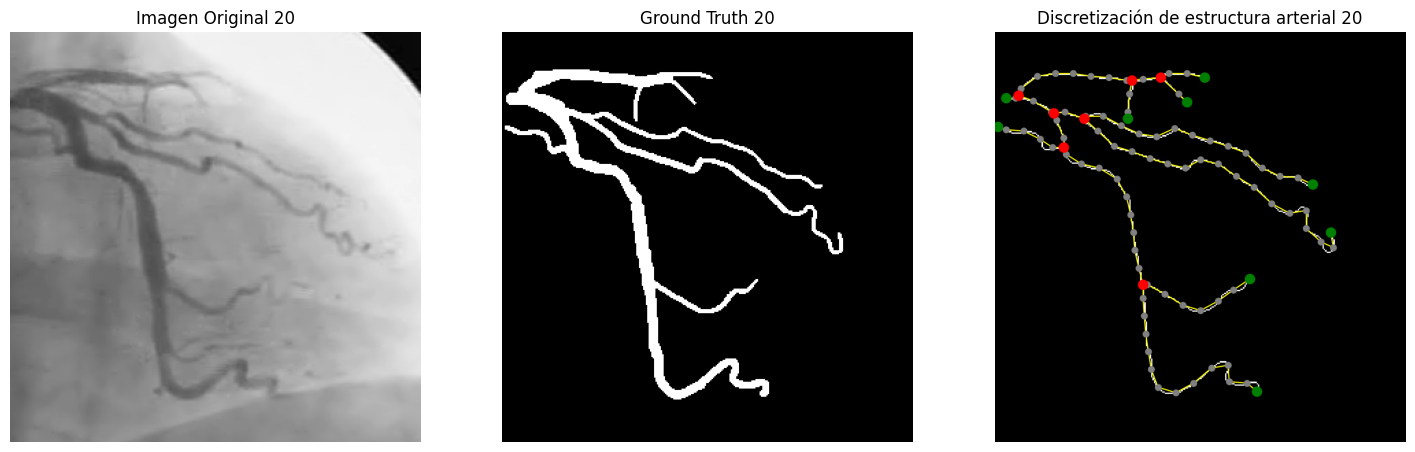

In [13]:
# Configurar rutas de entrada y salida
database_dir = "database"
json_output_dir = "graphs/json"
image_output_dir = "graphs/images"

# Procesar todas las imágenes
process_all_images(database_dir, json_output_dir, image_output_dir)